In [1]:
import networkx as nx
import numpy as np
import pandas as pd

## Schema Decomposition algorithms

In [2]:
def decomposition(g, depth=3, main = None):  # to find a decomposition plan with a minimal number of chains
    decompose = {'count':len(list(g.edges))+1}
    if main is None:
        nodes = list(g.nodes)
    else:
        nodes = [p for p in list(g.nodes) if p in main]  # only keep nodes in main
        
    paths = [[node] for node in nodes]
    outs = []
    while len(paths) > 0: # search main chain candidates
        paths_next = []
        for path in paths:
            next_step = list(g.adj[path[-1]])
            walk_flag = False
            for node in next_step:
                if node not in path:
                    walk_flag = True
                    break
            if walk_flag:
                paths_next.extend([path+[p] for p in next_step if p not in path])
            else:
                outs.append(path)
        paths = paths_next
        
    outs.sort(reverse=True,key=len)

    for main in outs:
        res = []
        g_tmp = nx.Graph()
        g_tmp.add_nodes_from(g.nodes)
        g_tmp.add_edges_from(g.edges)
        main_edges = [(main[i],main[i+1]) for i in range(len(main)-1)]
        g_tmp.remove_edges_from(main_edges)
        g_tmp.remove_nodes_from(list(nx.isolates(g_tmp)))
        # nx.draw(g_tmp, with_labels = True)
        ms = [[edge[0],edge[-1]] for edge in list(g_tmp.edges) if edge[0] in main and edge[-1] in main] # find subordinate chains
        g_tmp.remove_edges_from(ms)
        g_tmp.remove_nodes_from(list(nx.isolates(g_tmp)))
        if len(list(g_tmp.nodes)) > 0 and depth == 1:  # if reaches depth limitation but still has residual components
            continue
        elif len(list(g_tmp.nodes)) == 0:  # if no residual component left
            ms_num = len(ms) + 1  # +1 means add the number of main
            if ms_num < decompose['count']:  # if smaller, update plan
                decompose['count'] = ms_num
                decompose['ms'] = ms
                decompose['main'] = main
            else: continue
        else:
            # nx.draw(g_tmp, with_labels = True)
            depth -= 1
            for sub_g in nx.connected_components(g_tmp):
                sub_g = g_tmp.subgraph(sub_g)

                decompose_1 = decomposition(sub_g, depth, main)
                res.append(decompose_1)

            res_num = sum([p['count'] for p in res]) if len(res) > 0 else 0
            ms_num = len(ms) + 1 + res_num
            if ms_num < decompose['count']:  # smaller, update plan
                decompose['count'] = ms_num
                decompose['ms'] = ms
                decompose['main'] = main
                decompose['res'] = res
            else: continue # greater, skip this plan
    return decompose


def trans_decomp(schema, decompose, depth, to = 0):  # reorganize decomposition plan
    if 'res' in decompose.keys():
        res = decompose['res']
        depth += 1
        schema[depth] = {}
        for i, dcmp in enumerate(res):
            try:
                schema[depth][i] = {'main': dcmp['main'], 'to': to} 
            except KeyError: # decomposition stoped too early
                print('depth_limitation is too small!')
            # depth, i, 'to' stand for: 
            # 'the i-th chain in depth-th layer should connect to the 'to'-th chain in (depth-1)-th layer' 
            if len(dcmp['ms']) > 0:
                schema[depth][i]['ms'] = dcmp['ms']
            if 'res' in dcmp.keys():
                    schema = trans_decomp(schema, dcmp, depth, i)
    return schema


def reorganization(decompose):
    depth = 0
    schema = {}
    schema[depth] = {}
    try:
        schema[depth][0] = {'main': decompose['main']} 
    except KeyError: # decomposition stoped too early
        print('depth_limitation is too small!')
    if len(decompose['ms']) > 0:
        schema[depth][0]['ms'] = decompose['ms']
    schema = trans_decomp(schema, decompose, depth)
    
    return schema

### Schema of DBLP

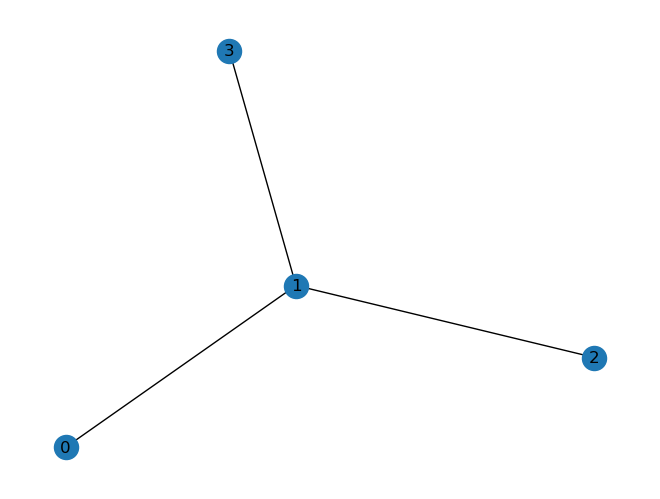

In [3]:
dblp = nx.Graph()
dblp.add_nodes_from(list(range(4)))
edge_list = [(0,1),(1,3),(1,2),] # 
dblp.add_edges_from(edge_list)
nx.draw(dblp, with_labels = True)

### Example schema

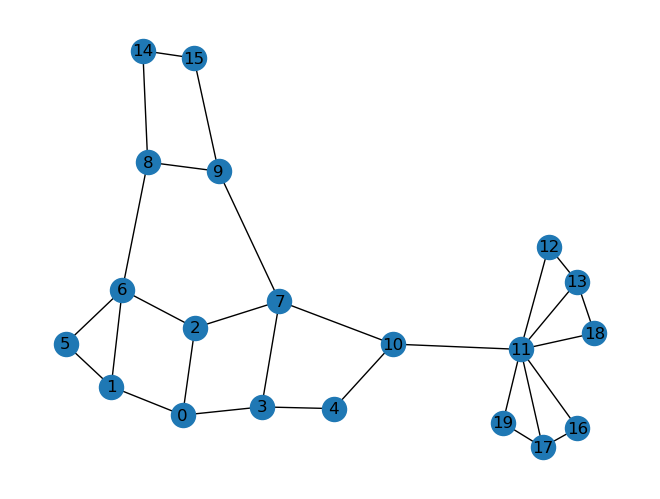

In [4]:
g1 = nx.Graph()
g1.add_nodes_from(list(range(20)))
edge_list = [(0,1),(0,2),(0,3),(1,6),(1,5),(2,6),(2,7),(3,4),(3,7),(4,10),(5,6),(6,8),(7,10),(7,9),(8,9),]
g1.add_edges_from(edge_list)
g1.add_edges_from([(10,11),(11,12),(11,13),(12,13),(8,14),(9,15),(14,15),(11,16),(11,17),(16,17),(18,11),(18,13),(19,11),(19,17)])
nx.draw(g1, with_labels = True)

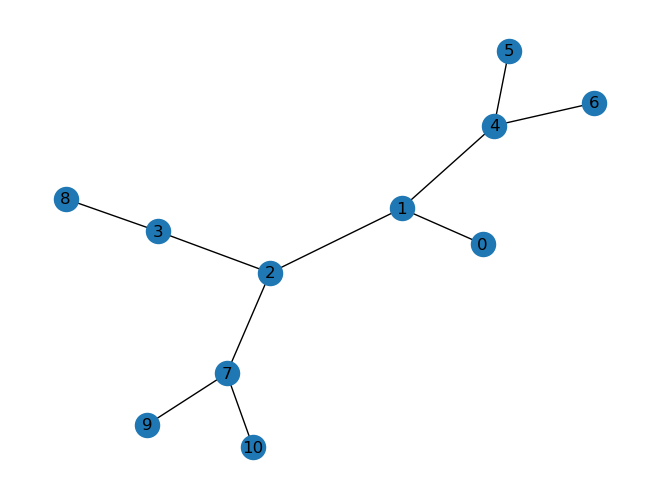

In [5]:
g2 = nx.Graph()
g2.add_nodes_from(list(range(11)))
edge_list = [(0,1),(1,2),(2,3),(2,7),(7,9),(1,4),(4,5),(4,6),(3,8),(7,10)] # 
g2.add_edges_from(edge_list)
nx.draw(g2, with_labels = True)

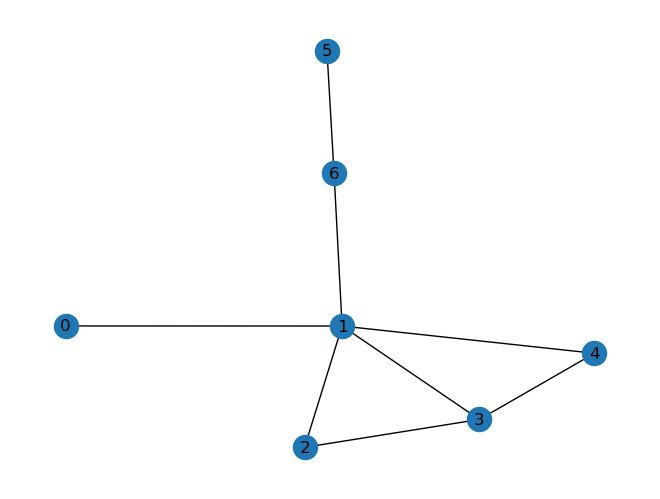

In [6]:
g3 = nx.Graph()
g3.add_nodes_from(list(range(7)))
edge_list = [(0,1),(1,2),(2,3),(1,3),(1,4),(3,4),(1,6),(5,6)] # 
g3.add_edges_from(edge_list)
nx.draw(g3, with_labels = True)

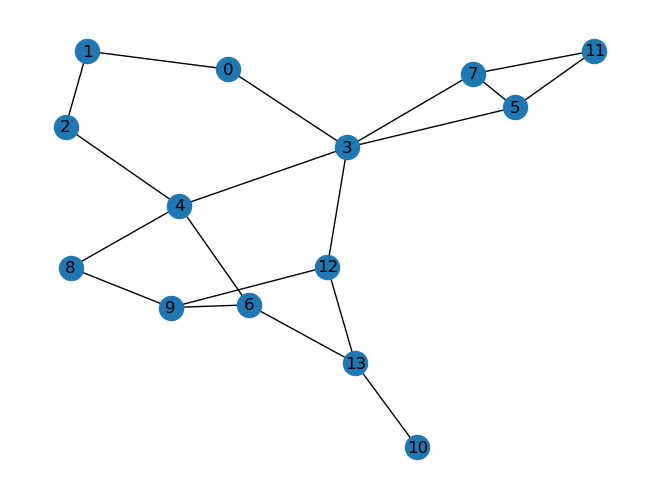

In [7]:
g4 = nx.Graph()
g4.add_nodes_from(list(range(14)))
edge_list = [(0,1),(0,3),(1,2),(2,4),(3,4),(3,5),(3,7),(3,12),(4,6),(4,8),(5,7),(5,11),(6,9),(6,13),(7,11),(8,9),(9,12),(10,13),(12,13)] # 
g4.add_edges_from(edge_list)
nx.draw(g4, with_labels = True)

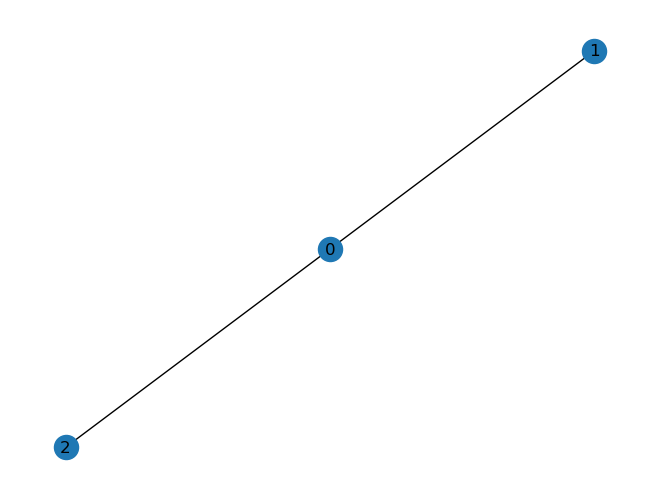

In [8]:
g5 = nx.Graph()
g5.add_nodes_from(list(range(3)))
edge_list = [(0,1),(0,2)] # 
g5.add_edges_from(edge_list)
nx.draw(g5, with_labels = True)

## Decomposition

In [39]:
depth_limitation = 3  # depth limitation
g = dblp
# g = g1
decompose = decomposition(g,depth_limitation)
decompose # is a recursive dict, call reorganization() to reorganize it


{'count': 2,
 'ms': [],
 'main': [0, 1, 3],
 'res': [{'count': 1, 'ms': [], 'main': [1, 2]}]}

### Reorganization

In [40]:
dcmp_plan = reorganization(decompose)
dcmp_plan

{0: {0: {'main': [0, 1, 3]}}, 1: {0: {'main': [1, 2], 'to': 0}}}

In [41]:
real_depth = len(dcmp_plan.keys())  # recursion depth
real_depth

2